# Classification of dermatoscopic images

Dataset: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

Source: Harvard Dataverse

Problem: classify pigmented skin lesions

Motivation: automatize the diagnostic from dermatoscopic images, without invasive and expensive interventions

Process’ summary:

1.	Metadata's exploration and description
2.	Understand how to extract and manipulate the images
    +  Reduction of the images' size
    +  Consider the greyscale space
3.	Treatment of the created matrix
    + 	Image vectorization
    + 	Merge the image matrix with the metadata 
    + 	Removal of the duplicate 
4.	Data partition and cross validation: training and test sets considering the balance of the classes
    +    Unbalanced problem
5.	Models
    + 	Random Forests
    + 	Neural Networks
    + 	Convolutional Neural Network

6.	Conclusions


## Exploration of the metadata

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#import metadata as panda dataframe
#first row is the name of the columns
#second column is the id of the images, lesions have more than one image
metadata = pd.read_csv('/gdrive/My Drive/IP_Project/metaData_dataBase/HAM10000_metadata.csv', header=0, index_col=1)
#print(metadata.head())
#print(metadata.info()) #10015 images, 6 columns
#counting the number of unique lesions
#print(metadata.lesion_id.value_counts()) #it is possible that the same lesion is repeated 6 times
#print(len(metadata.lesion_id.value_counts())) #7470 unique lesions!
#10015-7470
#(2545/10015)*100 #25.4118 %
metadatawithoutdup=metadata.drop_duplicates('lesion_id')

col_0  count
dx          
akiec    228
bcc      327
bkl      727
df        73
mel      614
nv      5403
vasc      98
col_0     count
dx             
akiec  0.030522
bcc    0.043775
bkl    0.097323
df     0.009772
mel    0.082195
nv     0.723293
vasc   0.013119
col_0  count
dx          
akiec    327
bcc      514
bkl     1099
df       115
mel     1113
nv      6705
vasc     142


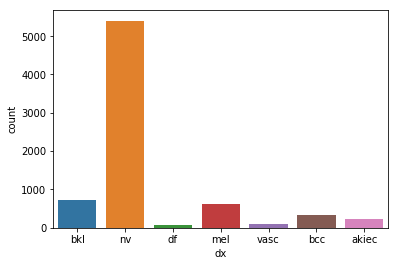

In [4]:
#classes
tab=pd.crosstab(index=metadatawithoutdup["dx"], columns="count")
print(tab)
#transform in percentage
print(tab/tab.sum())
ax = sns.countplot(x="dx", data=metadatawithoutdup)

tab1=pd.crosstab(index=metadata["dx"], columns="count")
print(tab1) #Melanoma without duplicates is 50%less

4
dx         akiec  bcc  bkl  df  mel    nv  vasc   All
dx_type                                              
confocal       0    0   34   0    0     0     0    34
consensus      0    0  206  44    0   332    65   647
follow_up      0    0    0   0    0  3704     0  3704
histo        228  327  487  29  614  1367    33  3085
All          228  327  727  73  614  5403    98  7470
4
dx         akiec  bcc   bkl   df   mel    nv  vasc    All
dx_type                                                  
confocal       0    0    69    0     0     0     0     69
consensus      0    0   264   60     0   503    75    902
follow_up      0    0     0    0     0  3704     0   3704
histo        327  514   766   55  1113  2498    67   5340
All          327  514  1099  115  1113  6705   142  10015


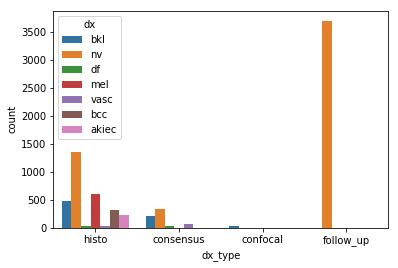

In [5]:
#Considering the dx_type (diagnosis way): more than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal).
#without duplicates
metadatawithoutdup.dx_type.value_counts() 
print(len(metadatawithoutdup.dx_type.value_counts())) #15 different localizations
print(pd.crosstab(metadatawithoutdup.dx_type, metadatawithoutdup.dx,margins=True))
ax = sns.countplot(x="dx_type",hue="dx", data=metadatawithoutdup)

#with duplicates
metadata.dx_type.value_counts() 
print(len(metadata.dx_type.value_counts())) #15 different localizations
print(pd.crosstab(metadata.dx_type, metadata.dx,margins=True))
#ax = sns.countplot(x="dx_type",hue="dx", data=metadata

               age
count  7418.000000
mean     51.658803
std      16.016472
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      85.000000
<class 'pandas.core.frame.DataFrame'>
Index: 7470 entries, ISIC_0027419 to ISIC_0033084
Data columns (total 6 columns):
lesion_id       7470 non-null object
dx              7470 non-null object
dx_type         7470 non-null object
age             7418 non-null float64
sex             7470 non-null object
localization    7470 non-null object
dtypes: float64(1), object(5)
memory usage: 728.5+ KB
None
0.6961178045515395
{'bcc', 'bkl', 'akiec', 'df', 'mel', 'vasc', 'nv'}


C:\Users\bella\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\bella\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0,0.5,'Density')

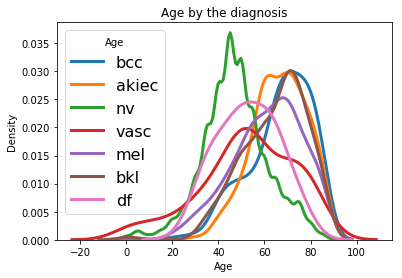

In [6]:
print(metadatawithoutdup.describe())
print(metadatawithoutdup.info())
print(((7470-7418)/7470)*100)
#study of the age by type
print(set(metadatawithoutdup.dx)) #return the classes
classes=['bcc', 'akiec', 'nv', 'vasc', 'mel', 'bkl', 'df']

metadata1=metadatawithoutdup
metadata1['age'].dropna()
# Iterate through the five airlines
for clas in classes:
    # Subset to the airline
    subset = metadata1[metadata1['dx'] == clas]
    
    # Draw the density plot
    sns.distplot(subset['age'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = clas)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Age')
plt.title('Age by the diagnosis')
plt.xlabel('Age')
plt.ylabel('Density')

dx,akiec,bcc,bkl,df,mel,nv,vasc,All
sex,,,,,,,,
female,80,122,304,38,243,2584,48,3419
male,148,205,414,35,371,2778,50,4001
unknown,0,0,9,0,0,41,0,50
All,228,327,727,73,614,5403,98,7470


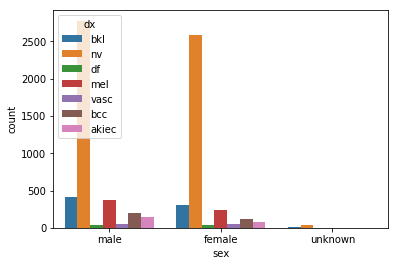

In [7]:
ax = sns.countplot(x="sex", hue="dx", data=metadatawithoutdup)
pd.crosstab(metadatawithoutdup.sex, metadatawithoutdup.dx,margins=True)

15
dx               akiec  bcc  bkl  df  mel    nv  vasc   All
localization                                               
abdomen              3    9   36   2   31   719    22   822
acral                0    0    0   0    0     3     0     3
back                22  123  133   1  185  1058    12  1534
chest                9   32   50   0   34   112     3   240
ear                  2    0    4   0   10    19     0    35
face                84   61  194   0   65    61     5   470
foot                 0    2    1   1   15   209     0   228
genital              0    0    1   1    0    43     0    45
hand                 8    1   12   0    1    39     3    64
lower extremity     41   36  109  54  104  1224    16  1584
neck                 8   11   20   0   18    60     2   119
scalp                8   11   24   0    9    24     2    78
trunk                1    6   57   0   25  1153    27  1269
unknown              0    3   19   0    6   175     0   203
upper extremity     42   32   67  14 

2.717536813922356

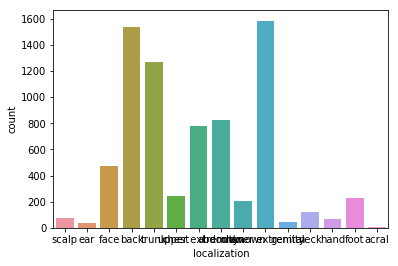

In [8]:
#localizaiton
metadatawithoutdup.localization.value_counts() 
print(len(metadatawithoutdup.localization.value_counts())) #15 different localizations
print(pd.crosstab(metadatawithoutdup.localization, metadatawithoutdup.dx,margins=True))
ax = sns.countplot(x="localization", data=metadatawithoutdup)
(203/7470)*100

 ## Extraction of the images, size's reduction, greyscale transformation

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')
# Seting the directory for the images 
# dir_zip_files = "/gdrive/My Drive/IP_Project/zipFiles"
# dir_unzip_files = "/gdrive/My Drive/IP_Project/DataBase"

#Seting the directory for the images 
dir_zip_files = 'D:\Python\Jupyter\IP_Project\zipFiles'
dir_unzip_files = 'D:\Python\Jupyter\IP_Project\DataBase'

In [ ]:
# #Seting the directory for the Metadata
# dir_MetaData_zip_files = "/gdrive/My Drive/IP_Project/metaDataZipFile"
# dir_MetaData_unzip_files = "/gdrive/My Drive/IP_Project/metaData_dataBase"

#Seting the directory for the Metadata
dir_MetaData_zip_files = 'D:\Python\Jupyter\IP_Project\metaDataZipFile'
dir_MetaData_unzip_files = 'D:\Python\Jupyter\IP_Project\metaData_dataBase'

In [ ]:
# Importing the packages
import os, zipfile # Extract files from a zip file
# ---
import csv
# ---
import numpy as np
import pandas as pd
import sys
import imageio
import glob
# ---
from os import listdir
from os.path import isfile, join
import numpy as np
import imageio
# --- 
import imageio
import matplotlib.pyplot as plt
# ---
import scipy.ndimage as ndi
# ---
from skimage.color import rgb2gray
import skimage.io as io
# ---
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
# ---
from PIL import Image
import os
import sys
from skimage import color
# ---
import fnmatch
# ---
from keras.models import Sequential
from sklearn.model_selection import train_test_split
# ---
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [ ]:
# #Extracting All Files From the Ziz File
# extension = ".zip"

# os.chdir(dir_zip_files) # change directory from working dir to dir with files

# # Loop to extract all Images from a the zip file on directory
# for item in os.listdir(dir_zip_files): # loop through items in dir
#     if item.endswith(extension): # check for ".zip" extension
#         file_name = os.path.abspath(item) # get full path of files
#         print("Processing %s" % file_name)
#         zip_ref = zipfile.ZipFile(file_name) # create zipfile object
#         os.chdir(dir_zip_files) # change directory from working dir to dir with files
#         zip_ref.extractall(dir_unzip_files) # extract file to dir
#         zip_ref.close() # close file
#         #os.remove(file_name) # delete zipped file

In [ ]:
# # Reading the the file names of the each image
# filenames = [os.path.splitext(filename)[0] for filename in os.listdir(dir_unzip_files) if filename.startswith("ISIC_")]
# filenames = pd.DataFrame(np.array(filenames).reshape(10015,1),columns=['filenames'])
# #filenames.head()

In [ ]:
# #metadata = pd.read_csv("/gdrive/My Drive/IP_Project/metaData_dataBase/HAM10000_metadata.csv")
# metadata = pd.read_csv("D:/Python/Jupyter/IP_Project/metaData_dataBase/HAM10000_metadata.csv")
# #print(type(metadata))
# #metadata.head()

In [ ]:
# # Merging the file names and the metadata, thus organizing the data.
# organized_metadata = pd.merge(left=filenames, right=metadata, left_on='filenames',right_on='image_id')
# #organized_metadata

In [ ]:
# # Creating list with duplicate files

# repeated_images = organized_metadata[organized_metadata["lesion_id"].duplicated()]
# #repeated_images.to_csv('D:/Python/Jupyter/IP_Project/metaData_dataBase/repeated_images.csv')
# repeated_images = repeated_images['filenames']

# organized_metadata = organized_metadata.drop_duplicates(subset=['lesion_id'],keep="first")
# #organized_metadata.to_csv('D:/Python/Jupyter/IP_Project/metaData_dataBase/organized_metadata.csv')

# unique_images = organized_metadata['filenames'] 
# #unique_images = unique_images.to_csv('D:/Python/Jupyter/IP_Project/metaData_dataBase/unique_images.csv') 

In [ ]:
# repeated_images_star = repeated_images + '.jpg'
# os.chdir('D:\Python\Jupyter\IP_Project\DataBase')
# for filename in repeated_images_star:
#     os.remove(filename)

In [ ]:
# Arranging the files and metadata again
# Reading the the file names of the each image
filenames = [os.path.splitext(filename)[0] for filename in os.listdir(dir_unzip_files) if filename.startswith("ISIC_")]
filenames = pd.DataFrame(np.array(filenames).reshape(7470,1),columns=['filenames'])
#filenames.head()
#metadata = pd.read_csv("/gdrive/My Drive/IP_Project/metaData_dataBase/HAM10000_metadata.csv")
#print(type(metadata))
#metadata.head()
# Merging the file names and the metadata, thus organizing the data.
organized_metadata = pd.merge(left=filenames, right=metadata, left_on='filenames',right_on='image_id')
#organized_metadata
#organized_metadata.to_csv("organized_metadata.csv")

In [ ]:
# # Decreasing the size of images (Resized_rgb)
# # From 600X450 to 200X150
# path = dir_unzip_files
# dirs = os.listdir( path )

# for file_name in os.listdir(path):
#   print("Processing %s" % file_name)
#   image = Image.open(os.path.join(path, file_name))

#   x,y = image.size
#   new_dimensions = (200, 150)
#   output = image.resize(new_dimensions, Image.ANTIALIAS)

#   output_file_name = os.path.join(path, "small_" + file_name)
#   output.save(output_file_name, "JPEG", quality = 95)

In [ ]:
# Read Images into a Skimage Image Collection
#images_gs = io.ImageCollection('/gdrive/My Drive/IP_Project/DataBase/small_ISIC*', conserve_memory=True, load_func=None)
images_rgb = io.ImageCollection('D:\Python\Jupyter\IP_Project\DataBase\small_ISIC*', conserve_memory=True, load_func=None)

In [ ]:
# Converting the Image Collection into a Numpy Array
images_rgb = io.concatenate_images(images_rgb)

In [ ]:
def normalize(x):
    return (x.astype(float) - 128) / 128

In [ ]:
norm_images_rgb = normalize(images_rgb)

In [ ]:
# Transforming the rgb dimensionto into Grayscale
images_gs = rgb2gray(images_rgb)

In [ ]:
images_gs.shape

In [ ]:
images_gs = images_gs.reshape(7470, 150, 200, 1)
images_rgb = images_rgb.reshape(7470, 150, 200, 3)
norm_images_rgb = norm_images_rgb.reshape(7470, 150, 200, 3)

In [ ]:
norm_images_rgb.shape

In [ ]:
plt.imshow(norm_images_rgb[0], cmap = 'gray')
#plt.colorbar()
plt.show()

In [ ]:
# Creating one-hot encoding (used in nn e cnn)

# Labels
labels = np.array(organized_metadata['dx'].tolist())
#print(type(labels))

# Classes
classes = np.array(["akiec","bcc","bkl","df","mel","nv","vasc"])
n_classes = len(classes)

# Initialize ohe_labels as all zeros
ohe_labels = np.zeros((len(labels), n_classes))

# Loop over the labels
for ii in range(len(labels)):
    # Find the location of this label in the categories variable
    jj = np.where(classes == labels[ii])
    # Set the corresponding zero to one
    ohe_labels[ii, jj] = 1
    
print(ohe_labels)

## Data matrix with images' features

After the extraction, transformation and reshape of the images in a matrix, we saved it and for random forests model we will work with it. With convulational neural networks, we tried to work directly with the images.

In [ ]:
import numpy as np
import pandas as pd
#DataMatrix 10015x30001, first column is the index
DataMatrix = pd.read_csv('DataMatrix.csv', index_col=0) #slow
DataMatrix.info()
#DataMatrix.head()

In [ ]:
#merge the dataMatrix with metadata to get the other variables
#print(DataMatrix.imageID)
#print(metadatawithoutdup.image_id)
mergeDataMatrix=pd.merge(metadatawithoutdup, DataMatrix, how='left', left_on="image_id", right_on="imageID")

In [ ]:
print(mergeDataMatrix.info())
print(mergeDataMatrix.head())

#mergeDataMatrix has already all the columns

In [ ]:
blabla=mergeDataMatrix[mergeDataMatrix.age.isnull()] #to write the report
tab1=pd.crosstab(index=blabla["dx"], columns="count")
tab1

## Imputation of the missing metadata by lesion type and type data transformations


In [ ]:
#imputation of age by median of the lesions' type
print(mergeDataMatrix.age.isnull().sum()) #52
#print(mergeDataMatrix[mergeDataMatrix.age.isnull()])
print(mergeDataMatrix.groupby('dx')['age'].median()) 
for i in range(0,7469):  
    if(np.isnan(mergeDataMatrix.age[i])):
        if mergeDataMatrix.dx[i]=="akiec":
            mergeDataMatrix.age[i]=67.5 #maybe round it?
        elif mergeDataMatrix.dx[i]=="bcc":
            mergeDataMatrix.age[i]=70.0
        elif mergeDataMatrix.dx[i]=="bkl":
            mergeDataMatrix.age[i]=65.0
        elif mergeDataMatrix.dx[i]=="df":
            mergeDataMatrix.age[i]=55.0
        elif mergeDataMatrix.dx[i]=="mel":
            mergeDataMatrix.age[i]=65.0
        elif mergeDataMatrix.dx[i]=="nv":
            mergeDataMatrix.age[i]=45.0
        else:
            mergeDataMatrix.age[i]=55.0

print(mergeDataMatrix.age.isnull().sum()) 
mergeDataMatrix.age=pd.to_numeric(mergeDataMatrix.age)

In [ ]:
#imputation of the sex
count=0
for i in range(0,7469):  
    if(mergeDataMatrix.sex[i]=="unknown"):
        mergeDataMatrix.sex[i]="male" #because 9 bkl has the mode in male, 41 nv has the mode in male
        count=count+1
        
        
print(count) #50 are the unknow

In [ ]:
#imputation of the localization
count1=0
for i in range(0,7469):  
    if(mergeDataMatrix.localization[i]=="unknown"):
        if mergeDataMatrix.dx[i]=="bcc":
            mergeDataMatrix.localization[i]="back"
            count1=count1+1
        elif mergeDataMatrix.dx[i]=="bkl":
            mergeDataMatrix.localization[i]="face"
            count1=count1+1
        elif mergeDataMatrix.dx[i]=="mel":
            mergeDataMatrix.localization[i]="back"
            count1=count1+1
        else:
            mergeDataMatrix.localization[i]="lower extremity" #nv
            count1=count1+1
        
print(count1) #203 missing values imputed, ok

In [ ]:
#transform the categorical variable in the appropriate type

#target
mergeDataMatrix['dxCat'] = pd.Categorical(mergeDataMatrix['dx'])

#localization
mergeDataMatrix['localizationCat']= pd.Categorical(mergeDataMatrix['localization'])

#sex
mergeDataMatrix['sexCat']= pd.Categorical(mergeDataMatrix['sex'])


#try to create a new aggregated variable for location, reducing the number of levels from 15 to?
#https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree

dt = DecisionTreeClassifier(max_depth=6)

locdumm = pd.get_dummies(mergeDataMatrix['localizationCat'],drop_first=True)
targetdumm= pd.get_dummies(mergeDataMatrix['dxCat'],drop_first=True)

dt.fit(locdumm , targetdumm)

In [ ]:
#print the decion tree
#creating a word
dotfile = open("dt.dot", 'w')
tree.export_graphviz(dt, out_file=dotfile, feature_names=list(locdumm), class_names=list(targetdumm))
dotfile.close()
#http://webgraphviz.com/ copy and paste the word text in here
#the variables used are: face, trunk, chest, scalp, back, upper extremity
#but... 

In [ ]:
print(mergeDataMatrix.info())
print(mergeDataMatrix.head())

## Principal Component Analysis

In [ ]:
onlynumerical_imag=mergeDataMatrix.drop(['lesion_id', 'image_id','dx','dx_type', 'age', 'sex', 'localization', 'imageID', 'dxCat', 'localizationCat', 'sexCat'],axis=1)
print(onlynumerical_imag.info())

In [ ]:
#standardizing
#scaling the 30 000 variables
from sklearn.preprocessing import StandardScaler

# Separating out the features
x = onlynumerical_imag
# Standardizing the features
onlynumerical_imag_scaled = StandardScaler().fit_transform(onlynumerical_imag)

In [ ]:
print(onlynumerical_imag_scaled)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(onlynumerical_imag_scaled)

In [ ]:
print(pca.explained_variance_ratio_)
c=pca.explained_variance_ratio_
np.savetxt("c.csv", c, delimiter=",")
print(pca.singular_values_)
b=pca.singular_values_
np.savetxt("b.csv", b, delimiter=",")
print(pca.explained_variance_ratio_.cumsum())
a=pca.explained_variance_ratio_.cumsum()
np.savetxt("a.csv", a, delimiter=",")
#162 variables to consider to have 95% of variance explained

In [ ]:
principalDf = pd.DataFrame(data = principalComponents[:, 0:162])
principalDf.info()

#age can be not standardized, standardize depending on the algorithm
locdumm = pd.get_dummies(mergeDataMatrix['localizationCat'],drop_first=True)
sexdumm= pd.get_dummies(mergeDataMatrix['sex'],drop_first=True)

#target= pd.get_dummies(mergeDataMatrix['dx']) #Not drop in the target case

finalDf = pd.concat([principalDf, mergeDataMatrix[['age']], locdumm, sexdumm], axis = 1)
print(finalDf.info())

y=mergeDataMatrix['dxCat']

## Data Partition

In [ ]:
# Spliting test set and training set
from sklearn.model_selection import train_test_split

data_train1, data_test1, label_train1, label_test1 = train_test_split(finalDf, y, test_size=0.10,random_state=1234, stratify=y)

# Random Forests
No hypertuning of the parameters

### First try

In [ ]:
#Random Forests
print('Training Features Shape:', data_train1.shape)
print('Training Labels Shape:', label_train1.shape)
print('Testing Features Shape:', data_test1.shape)
print('Testing Labels Shape:', label_test1.shape)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1234)
# Train the model on training data
rf.fit(data_train1, label_train1);

In [ ]:
y_pred=rf.predict(data_test1)
#print(y_pred)
print(set(y_pred))

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(label_test1, y_pred)) #Accuracy: 0.7376171352074966

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

print(pd.crosstab(label_test1, y_pred, rownames=['Actual'], colnames=['Predicted']))

### Second try
Undesampling the majority class randomly to try to balance the classes.

We don't know if the classes are not equally relevant also in the reality or it is just a problem of data collection. If it is just a problem of data collection, then, wrongly, the balance is done before the partition of training and test sets.

In [ ]:
temp=mergeDataMatrix.loc[~mergeDataMatrix['dx'].isin(['nv', 'df', 'vasc'])]
print(temp.info()) #1896 entries
print(228+327+727+614)

In [ ]:
#undersampling, easy way
nvclass=mergeDataMatrix[mergeDataMatrix.dx=='nv']
print(nvclass.info()) #5403 entries

redct=5403/3
print(redct)

redct1=int(round(redct)) #need to be integer

from random import sample 
nvred=nvclass.sample(n=redct1)
print(nvred.info()) #1801

#not considering df class and vasc class because <100
#considering 1/3*nv
tab=pd.crosstab(index=mergeDataMatrix["dx"], columns="count")
print(tab)

In [ ]:
#concatenate with a random sample of the majority class
finalDfbalanced = pd.concat([temp, nvred], axis = 0)
print(finalDfbalanced.info()) #3697
print(1896+1801) #doing like that the most frequent class is <50%, not of a lot, but at least the accuracy will not be biased as much as before

In [ ]:
#shuffle the order
finalDfbalanced1=finalDfbalanced.sample(frac=1) #frac=1 
print(finalDfbalanced1.info()) #3697 entries

#PCA again

onlynumerical_imag1=finalDfbalanced1.drop(['lesion_id', 'image_id','dx','dx_type', 'age', 'sex', 'localization', 'imageID'],axis=1)
#onlynumerical_imag1=finalDfbalanced1.drop(['lesion_id', 'image_id','dx','dx_type', 'age', 'sex', 'localization', 'imageID', 'dxCat', 'localizationCat', 'sexCat'],axis=1)

print(onlynumerical_imag1.info())

#standardizing
#scaling the 30 000 variables
from sklearn.preprocessing import StandardScaler

# Separating out the features
x1 = onlynumerical_imag1
# Standardizing the features
onlynumerical_imag_scaled1 = StandardScaler().fit_transform(onlynumerical_imag1)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(0.95) #to keep just the components that explain the 95% of the total variance
principalComponents1 = pca.fit_transform(onlynumerical_imag_scaled1)


In [ ]:
print(principalComponents1.shape)

In [ ]:
print(pca.explained_variance_ratio_)
c1=pca.explained_variance_ratio_
np.savetxt("c1.csv", c1, delimiter=",")
print(pca.singular_values_)
b1=pca.singular_values_
np.savetxt("b1.csv", b1, delimiter=",")
print(pca.explained_variance_ratio_.cumsum())
a1=pca.explained_variance_ratio_.cumsum()
np.savetxt("a1.csv", a1, delimiter=",")
#175 variables to consider to have 95% of variance explained
principalDf175 = pd.DataFrame(principalComponents1)
principalDf175.info()

In [ ]:
#Visualize one image before and after PCA
approximation = pca.inverse_transform(principalDf175)


In [ ]:
onlynumerical_imag1_imag = onlynumerical_imag1.values
onlynumerical_imag1_imag1=onlynumerical_imag1_imag.reshape(3697, 150, 200)
print(onlynumerical_imag1_imag.shape) #(3697, 30000)
print(onlynumerical_imag1_imag1.shape) #(3697, 150, 200)
#print(onlynumerical_imag1_imag)
print(approximation.shape)
approximation_image=approximation.reshape(3697, 150, 200)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4));


#plt.imshow(onlynumerical_imag1_imag[1], cmap = 'gray')

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(onlynumerical_imag1_imag1[3]);
plt.xlabel('5899 dimensions', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 154 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation_image[3]);
plt.xlabel('175 principal components', fontsize = 14)
plt.title('95% of Explained Variance', fontsize = 20);

In [ ]:
#age can be not standardized, standardize depending on the algorithm

finalDfbalanced1['localizationCat']= pd.Categorical(finalDfbalanced1['localization'])
finalDfbalanced1['sexCat']= pd.Categorical(finalDfbalanced1['sex'])
finalDfbalanced1['dxCat']= pd.Categorical(finalDfbalanced1['dx'])


locdumm1 = pd.get_dummies(finalDfbalanced1['localizationCat'],drop_first=True)
sexdumm1= pd.get_dummies(finalDfbalanced1['sex'],drop_first=True)


#finalDf = pd.concat([principalDf175, finalDfbalanced1['age']], axis = 1)
locdumm1.shape

principalDf175.shape
principalDf175.info() #RangeIndex: 3697 entries, 0 to 3696
principalDf175.head()



finalDf = pd.concat([finalDfbalanced1['age'], locdumm1, sexdumm1], axis = 1)

finalDf.info() #Int64Index: 3697 entries, 2512 to 4126
#reset the index
finalDf.info()
finalDf=finalDf.reset_index()#otherwise doesn't work the concat propertly
finalDf.info()

finalDf1 = pd.concat([finalDf, principalDf175], axis = 1)
#finalDf1 = pd.concat([principalDf175, finalDfbalanced1['age'], locdumm1, sexdumm1], axis = 1)
#finalDf = pd.concat([principalDf175, finalDfbalanced1['age']], axis = 1)

print(finalDf1.info())
print(finalDf1.shape)

y=finalDfbalanced1['dxCat']
y.shape

In [ ]:
# Spliting test set and training set
from sklearn.model_selection import train_test_split

data_train1, data_test1, label_train1, label_test1 = train_test_split(finalDf1, y, test_size=0.10,random_state=1234, stratify=y)

In [ ]:
#Random Forests
print('Training Features Shape:', data_train1.shape)
print('Training Labels Shape:', label_train1.shape)
print('Testing Features Shape:', data_test1.shape)
print('Testing Labels Shape:', label_test1.shape)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1234)
# Train the model on training data
rf.fit(data_train1, label_train1);

In [ ]:
y_pred=rf.predict(data_test1)
#print(y_pred)
print(set(y_pred))

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(label_test1, y_pred)) #Accuracy:  0.9432432432432433

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

print(pd.crosstab(label_test1, y_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted  akiec  bcc  bkl  mel   nv
Actual                              
bcc            0   20    0   13    0
bkl            0    0   73    0    0
nv             1    0    0    0  179
mel            0    0    0   61    0
akiec         16    0    0    0    7

### Fast cross validation of Random Forest

In [ ]:
#crossvalidation
data_train1, data_test1, label_train1, label_test1 = train_test_split(finalDf1, y, test_size=0.10,random_state=5678, stratify=y)
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1234)
rf.fit(data_train1, label_train1);

In [ ]:
y_pred=rf.predict(data_test1)
#print(y_pred)
print(set(y_pred))

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(label_test1, y_pred)) #Accuracy:  0.9405405405405406

print(pd.crosstab(label_test1, y_pred, rownames=['Actual'], colnames=['Predicted']))

{'bcc', 'akiec', 'bkl', 'nv', 'mel'}
Accuracy: 0.9405405405405406
Predicted  akiec  bcc  bkl  mel   nv
Actual                              
nv             0    0    0    0  180
mel            0    1    0   60    0
bkl            0    0   72    0    1
bcc            0   25    0    8    0
akiec         11    0    0    0   12

In [ ]:
#crossvalidation
data_train1, data_test1, label_train1, label_test1 = train_test_split(finalDf1, y, test_size=0.10,random_state=9101112, stratify=y)
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1234)
rf.fit(data_train1, label_train1);
y_pred=rf.predict(data_test1)
#print(y_pred)
print(set(y_pred))

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(label_test1, y_pred)) #Accuracy:  0.9216216216216216

print(pd.crosstab(label_test1, y_pred, rownames=['Actual'], colnames=['Predicted']))

{'bcc', 'akiec', 'bkl', 'nv', 'mel'}
Accuracy: 0.9216216216216216
Predicted  akiec  bcc  bkl  mel   nv
Actual                              
bcc            0   13    0   20    0
nv             0    0    0    0  180
bkl            0    0   72    0    1
akiec         17    0    0    0    6
mel            0    0    2   59    0

## Neural Networks

No tuning the parameters.
Without balance the classes.

In [ ]:
# Trying to create the first NN

# Imports components from Keras
from keras.models import Sequential
from keras.layers import Dense

# Initializes a sequential model
model = Sequential()

# First layer
model.add(Dense(10, activation='relu', input_shape=(30000,)))

# Second layer
model.add(Dense(10, activation='relu'))

# Third layer
model.add(Dense(10, activation='relu'))

# # Fourth layer
model.add(Dense(10, activation='relu'))

# Output layer
model.add(Dense(7, activation='softmax'))

In [ ]:
from sklearn.model_selection import train_test_split

data_train1, data_test1, label_train1, label_test1 = train_test_split(images_gs, ohe_labels, test_size=0.10,random_state=1234)
data_train2, data_validate2, label_train2, label_validate2 = train_test_split(data_train1, label_train1, test_size = 0.2, random_state = 2)

In [ ]:
# Compile the model
model.compile(optimizer='adam',         
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

data_train1 = data_train1.reshape(len(data_train1),30000) #flat
# label_train1.reshape(len(label_train1),30000)

model.fit(data_train1, label_train1, 
          validation_split=0.2,
          epochs=3)

data_test1 = data_test1.reshape(len(data_test1), 30000)

model.evaluate(data_test1, label_test1)


In [ ]:
# 1
# print(data_train1.shape)
# print(label_train1.shape)

# print(data_test1.shape)
# print(label_test1.shape)
len(data_train1)
#train_data = images_rgb.reshape(10015, 90000)
train_data = data_train1.reshape(len(data_train1), 30000)

In [ ]:
print(type(train_data))
print(train_data.shape)

In [ ]:
model.fit(train_data, ohe_labels,
         validation_split=0.2,
         epochs=3)

## Convolutional neural network

No tuning the parameters.
Without balance the classes.

### First try, using grey scale images

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model = Sequential()
model.add(Conv2D(10, kernel_size=3, activation='relu', 
              input_shape=(150, 200, 1)))#3 DIMENSIONS, 1 COLOR

model.add(Flatten())
model.add(Dense(7, activation='softmax'))

In [ ]:
# Spliting test set and training set
from sklearn.model_selection import train_test_split

data_train1, data_test1, label_train1, label_test1 = train_test_split(images_gs, ohe_labels, test_size=0.10,random_state=1234)

In [ ]:
# Fitting a CNN - with grayscale dataset
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(data_train1, label_train1, validation_split=0.2, epochs=3)

[test_loss, test_acc] = model.evaluate(data_test1, label_test1, verbose=0)
# model.evaluate(data_test1, label_test1, epochs=3)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

### Second try, using rgb images

In [ ]:
# Implementing Image Convolutions in Keras -> For rgb images
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model = Sequential()
model.add(Conv2D(10, kernel_size=3, activation='relu', 
              input_shape=(150, 200, 3))) #3DIMENSIONS, 3 COLOR

model.add(Flatten())
model.add(Dense(7, activation='softmax'))

In [ ]:
# Spliting test set and training set
from sklearn.model_selection import train_test_split

data_train1, data_test1, label_train1, label_test1 = train_test_split(images_rgb, ohe_labels, test_size=0.10,random_state=1234)

In [ ]:
# Fitting a CNN - with rgb dataset
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(data_train1, label_train1, validation_split=0.2, epochs=3)

[test_loss, test_acc] = model.evaluate(data_test1, label_test1, verbose=0)
# model.evaluate(data_test1, label_test1, epochs=3)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

### Third try, deep net

In [ ]:
# Implementing Image Convolutions in Keras -> Deeper nets
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model = Sequential()
model.add(Conv2D(10, kernel_size=2, activation='relu', 
                 input_shape=(150, 200, 3), 
                 padding='same'))

# Second convolutional layer
model.add(Conv2D(10, kernel_size=2, activation='relu'))
          
model.add(Flatten())
model.add(Dense(9, activation='softmax'))

In [ ]:
# Spliting test set and training set
from sklearn.model_selection import train_test_split

data_train1, data_test1, label_train1, label_test1 = train_test_split(norm_images_rgb, ohe_labels, test_size=0.10,random_state=1234)

In [ ]:
print("Fitting a 2 Layers CNN - with normalized rgb dataset")
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(data_train1, label_train1, validation_split=0.2, epochs=3)

[test_loss, test_acc] = model.evaluate(data_test1, label_test1, verbose=0)
# model.evaluate(data_test1, label_test1, epochs=3)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

In [ ]:
epochs = 3
batch_size = 10
history = model.fit_generator(datagen.flow(data_train1,label_train1, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

### Other experiments

Trying deep neural network with data augmentation too.

In [ ]:
#In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D


input_shape = (150, 200, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
# With data augmentation to prevent overfitting 

data_train1, data_test1, label_train1, label_test1 = train_test_split(norm_images_rgb, ohe_labels, test_size=0.10,random_state=1234)
data_train2, data_validate2, label_train2, label_validate2 = train_test_split(data_train1, label_train1, test_size = 0.2, random_state = 2)

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(data_train2)

In [ ]:
print(data_train1.shape)
print(data_test1.shape)
print(label_train1.shape)
print(label_test1.shape)

In [ ]:
# Fit the model
from functools import reduce

epochs = 3 
batch_size = 1
history = model.fit_generator(datagen.flow(data_train2,label_train2, batch_size=batch_size),
                              epochs = epochs, validation_data = (data_validate2,label_validate2),
                              verbose = 1, steps_per_epoch=data_train2.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

In [ ]:
# Model Evaluation
loss, accuracy = model.evaluate(data_validate2, label_validate2, verbose=1)
loss_v, accuracy_v = model.evaluate(data_test1, label_test1, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

### Try CNN with balanced classes

Also deep Convolutional neural networks can't classify the minor classes, then we tried to see what happens with the balanced classes also in this case.

In [ ]:
#trying the ccn
from keras.models import Sequential
from sklearn.model_selection import train_test_split
# ---
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import keras
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D


input_shape = (150, 200, 1)
num_classes = 5

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
onlynumerical_imag1.shape

In [ ]:
onlynumerical_imag11=onlynumerical_imag1.reshape(3697, 150, 200, 1)
onlynumerical_imag11.shape
y.shape

y1=pd.get_dummies(y)
y1.shape

In [ ]:
# With data augmentation to prevent overfitting 
data_train1, data_test1, label_train1, label_test1 = train_test_split(onlynumerical_imag11,y1, test_size=0.10,random_state=1234,  stratify=y)

data_train2, data_validate2, label_train2, label_validate2 = train_test_split(data_train1, label_train1, test_size = 0.2, random_state = 2)

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(data_train2)

In [ ]:
# Fit the model
from functools import reduce

epochs = 3 
batch_size = 1
history = model.fit_generator(datagen.flow(data_train2,label_train2, batch_size=batch_size),
                              epochs = epochs, validation_data = (data_validate2,label_validate2),
                              verbose = 1, steps_per_epoch=data_train2.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/3
2661/2661 [==============================] - 1076s 404ms/step - loss: 1.4050 - acc: 0.4821 - val_loss: 1.3579 - val_acc: 0.4910
Epoch 2/3
2661/2661 [==============================] - 1068s 401ms/step - loss: 1.3802 - acc: 0.4863 - val_loss: 1.3567 - val_acc: 0.4910
Epoch 3/3
2661/2661 [==============================] - 1018s 383ms/step - loss: 1.3643 - acc: 0.4863 - val_loss: 1.3583 - val_acc: 0.4910

In [ ]:
# Model Evaluation
loss, accuracy = model.evaluate(data_validate2, label_validate2, verbose=1)
loss_v, accuracy_v = model.evaluate(data_test1, label_test1, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

666/666 [==============================] - 31s 47ms/step
370/370 [==============================] - 17s 46ms/step
Validation: accuracy = 0.486486  ;  loss_v = 1.357561
Test: accuracy = 0.490991  ;  loss = 1.358307

In [ ]:
y_pred=model.predict_classes(data_test1)

#print(pd.crosstab(y1, list(y_pred), rownames=['Actual'], colnames=['Predicted'])) #still problems with cnn also with balanced classes

y_pred.shape

## Conclusions

Because of the complexity of the problems, many other techniques could be explored. 
We think that a better image pre-processing could make the prediction improves: considering, for example, the spatial correlation, the reduction of the space by pixel positions, some filters of the image’s noises and many other treatments. Moreover, it would be possible to explore and test better different undersampling/oversampling techniques and maybe, also ensemble different models with different datasets to have a more stable classification in the validation. 
Additionally, many parameters could be tested and tuned to better personalize the model but always considering a good trade-off between the goodness of the model and the ability of generalization. 